# Thư viện

In [18]:
import pandas as pd
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, roc_auc_score
import joblib
from rdflib import Graph, Namespace, RDF, RDFS, OWL

# Train mô hình

## Mô hình Random Forest

In [19]:
df = pd.read_csv("data.csv")

df['Intent'] = df['Intent'].apply(lambda x: eval(x) if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df['Intent'])

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['Question'])

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_tfidf, y_encoded, test_size=0.4, random_state=42)

param_grid = {
    'estimator__n_estimators': [10, 20, 25],
    'estimator__max_depth': [5, 10, 15]
}
grid_search_RF = GridSearchCV(  
    MultiOutputClassifier(RandomForestClassifier(random_state=42)),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search_RF.fit(X_train_RF, y_train_RF)

results_RF = pd.DataFrame(grid_search_RF.cv_results_)
model_RF = grid_search_RF.best_estimator_

In [20]:
print("\nAccuracy cho mỗi tổ hợp tham số trong Grid Search:")
for i in range(len(results_RF)):
    n_estimators = results_RF['param_estimator__n_estimators'][i]
    max_depth = results_RF['param_estimator__max_depth'][i]
    mean_accuracy = results_RF['mean_test_score'][i]
    std_accuracy = results_RF['std_test_score'][i]
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")

print("\nTham số tốt nhất từ Grid Search:", grid_search_RF.best_params_)
print("Accuracy tốt nhất trên tập validation (CV):", grid_search_RF.best_score_)

y_pred_RF = model_RF.predict(X_test_RF)

# 1. Accuracy (tỷ lệ mẫu dự đoán đúng toàn bộ nhãn)
accuracy_RF = accuracy_score(y_test_RF, y_pred_RF)

# 2. Hamming Loss (tỷ lệ nhãn dự đoán sai)
hamming_RF = hamming_loss(y_test_RF, y_pred_RF)

# 3. Precision, Recall, F1-score cho từng nhãn
precision_RF, recall_RF, f1_RF, _ = precision_recall_fscore_support(y_test_RF, y_pred_RF, average=None, labels=np.arange(len(mlb.classes_)))

# 4. Subset Accuracy (tỷ lệ mẫu dự đoán đúng tất cả nhãn)
subset_accuracy_RF = np.mean([np.array_equal(y_test_RF[i], y_pred_RF[i]) for i in range(len(y_test_RF))])

print("\nKết quả trên tập test:")
print(f"Accuracy: {accuracy_RF:.4f}")
print(f"Hamming Loss: {hamming_RF:.4f}")
print(f"Subset Accuracy: {subset_accuracy_RF:.4f}")
print("\nPrecision, Recall, F1-score cho từng nhãn:")
for i, label in enumerate(mlb.classes_):
    print(f"{label}: Precision: {precision_RF[i]:.4f}, Recall: {recall_RF[i]:.4f}, F1-score: {f1_RF[i]:.4f}")


Accuracy cho mỗi tổ hợp tham số trong Grid Search:
n_estimators: 10, max_depth: 5, Accuracy: 0.7090 (±0.0639)
n_estimators: 20, max_depth: 5, Accuracy: 0.7792 (±0.0494)
n_estimators: 25, max_depth: 5, Accuracy: 0.7958 (±0.0529)
n_estimators: 10, max_depth: 10, Accuracy: 0.8729 (±0.0349)
n_estimators: 20, max_depth: 10, Accuracy: 0.8975 (±0.0179)
n_estimators: 25, max_depth: 10, Accuracy: 0.9106 (±0.0303)
n_estimators: 10, max_depth: 15, Accuracy: 0.9150 (±0.0244)
n_estimators: 20, max_depth: 15, Accuracy: 0.9264 (±0.0198)
n_estimators: 25, max_depth: 15, Accuracy: 0.9360 (±0.0198)

Tham số tốt nhất từ Grid Search: {'estimator__max_depth': 15, 'estimator__n_estimators': 25}
Accuracy tốt nhất trên tập validation (CV): 0.9360108787251973

Kết quả trên tập test:
Accuracy: 0.9238
Hamming Loss: 0.0350
Subset Accuracy: 0.9238

Precision, Recall, F1-score cho từng nhãn:
Nguyên nhân: Precision: 0.9831, Recall: 0.9879, F1-score: 0.9855
Triệu chứng: Precision: 0.9412, Recall: 0.9435, F1-score: 0


Ma trận nhầm lẫn cho từng nhãn:

Nhãn: Nguyên nhân
[[342   7]
 [  5 407]]
  True Negative (TN): 342
  False Positive (FP): 7
  False Negative (FN): 5
  True Positive (TP): 407

Nhãn: Triệu chứng
[[330  24]
 [ 23 384]]
  True Negative (TN): 330
  False Positive (FP): 24
  False Negative (FN): 23
  True Positive (TP): 384

Nhãn: Điều trị
[[325  11]
 [ 10 415]]
  True Negative (TN): 325
  False Positive (FP): 11
  False Negative (FN): 10
  True Positive (TP): 415


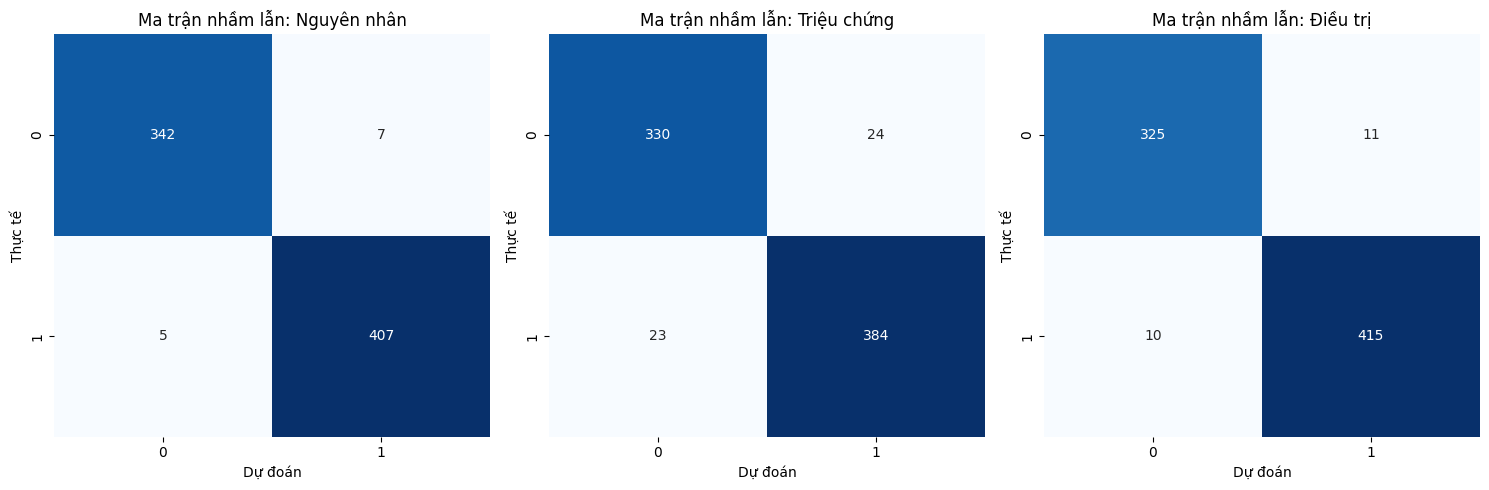

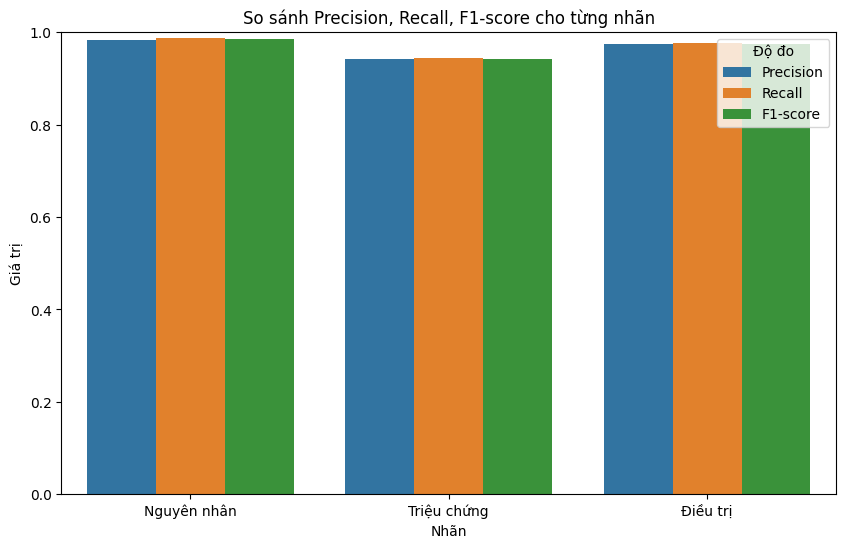

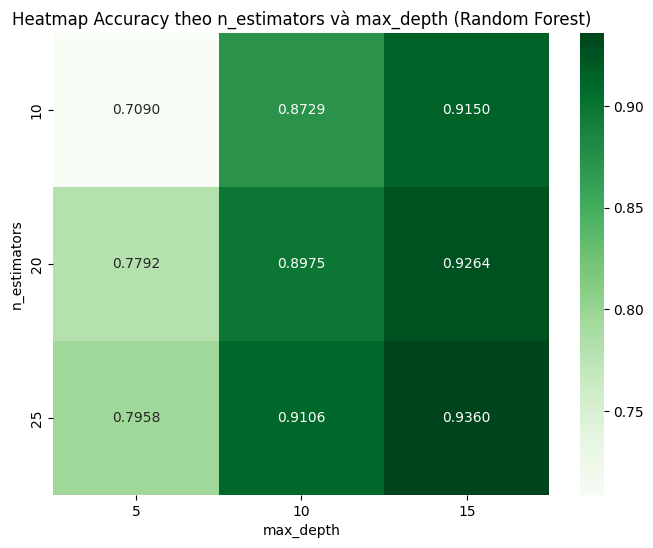

In [21]:
# 5. Ma trận nhầm lẫn cho từng nhãn
print("\nMa trận nhầm lẫn cho từng nhãn:")
confusion_matrices = []
for i, label in enumerate(mlb.classes_):
    print(f"\nNhãn: {label}")
    cm = confusion_matrix(y_test_RF[:, i], y_pred_RF[:, i])
    confusion_matrices.append(cm)
    
    print(cm)
    print(f"  True Negative (TN): {cm[0, 0]}")
    print(f"  False Positive (FP): {cm[0, 1]}")
    print(f"  False Negative (FN): {cm[1, 0]}")
    print(f"  True Positive (TP): {cm[1, 1]}")

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(15, 5))
for i, (cm, label) in enumerate(zip(confusion_matrices, mlb.classes_)):
    plt.subplot(1, len(mlb.classes_), i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Ma trận nhầm lẫn: {label}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.xticks([0.5, 1.5], ['0', '1'])
    plt.yticks([0.5, 1.5], ['0', '1'])
plt.tight_layout()
plt.show()

# Trực quan hóa Precision, Recall, F1-score
metrics_df = pd.DataFrame({
    'Nhãn': mlb.classes_,
    'Precision': precision_RF,
    'Recall': recall_RF,
    'F1-score': f1_RF
})
metrics_df = metrics_df.melt(id_vars='Nhãn', var_name='Độ đo', value_name='Giá trị')

plt.figure(figsize=(10, 6))
sns.barplot(x='Nhãn', y='Giá trị', hue='Độ đo', data=metrics_df)
plt.title('So sánh Precision, Recall, F1-score cho từng nhãn')
plt.ylim(0, 1)
plt.legend(title='Độ đo')
plt.show()

# Heatmap cho Random Forest
rf_pivot = pd.pivot_table(
    pd.DataFrame(results_RF),
    values='mean_test_score',
    index='param_estimator__n_estimators',
    columns='param_estimator__max_depth'
)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_pivot, annot=True, fmt='.4f', cmap='Greens')
plt.title('Heatmap Accuracy theo n_estimators và max_depth (Random Forest)')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

## Mô hình SVM

In [22]:
df = pd.read_csv("data.csv")

df['Intent'] = df['Intent'].apply(lambda x: eval(x) if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df['Intent'])

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['Question'])

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y_encoded, test_size=0.4, random_state=42)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
multi_svm = MultiOutputClassifier(svm_model)

param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__gamma': [0.01, 0.1, 1],
    'estimator__kernel': ['rbf', 'linear']
}

grid_search_svm = GridSearchCV(
    multi_svm,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(X_train_svm, y_train_svm)

results_svm = pd.DataFrame(grid_search_svm.cv_results_)
model_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [23]:
print("\nAccuracy cho mỗi tổ hợp tham số trong Grid Search:")
for i in range(len(results_svm)):
    C = results_svm['param_estimator__C'][i]
    gamma = results_svm['param_estimator__gamma'][i]
    kernel = results_svm['param_estimator__kernel'][i]
    mean_accuracy = results_svm['mean_test_score'][i]
    std_accuracy = results_svm['std_test_score'][i]
    print(f"C: {C}, gamma: {gamma}, kernel: {kernel}, Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")

print("\nTham số tốt nhất từ Grid Search:", grid_search_svm.best_params_)
print("Accuracy tốt nhất trên tập validation (CV):", grid_search_svm.best_score_)

y_pred_svm = model_svm.predict(X_test_svm)

# Tính các độ đo đánh giá
# 1. Accuracy (tỷ lệ mẫu dự đoán đúng toàn bộ nhãn)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)

# 2. Hamming Loss (tỷ lệ nhãn dự đoán sai)
hamming_svm = hamming_loss(y_test_svm, y_pred_svm)

# 3. Precision, Recall, F1-score cho từng nhãn
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test_svm, y_pred_svm, average=None, labels=np.arange(len(mlb.classes_)))

# 4. Subset Accuracy (tỷ lệ mẫu dự đoán đúng tất cả nhãn)
subset_accuracy_svm = np.mean([np.array_equal(y_test_svm[i], y_pred_svm[i]) for i in range(len(y_test_svm))])

# In kết quả
print("\nKết quả trên tập test:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Hamming Loss: {hamming_svm:.4f}")
print(f"Subset Accuracy: {subset_accuracy_svm:.4f}")
print("\nPrecision, Recall, F1-score cho từng nhãn:")
for i, label in enumerate(mlb.classes_):
    print(f"{label}: Precision: {precision_svm[i]:.4f}, Recall: {recall_svm[i]:.4f}, F1-score: {f1_svm[i]:.4f}")


Accuracy cho mỗi tổ hợp tham số trong Grid Search:
C: 0.1, gamma: 0.01, kernel: rbf, Accuracy: 0.1297 (±0.0151)
C: 0.1, gamma: 0.01, kernel: linear, Accuracy: 0.8317 (±0.0411)
C: 0.1, gamma: 0.1, kernel: rbf, Accuracy: 0.1297 (±0.0151)
C: 0.1, gamma: 0.1, kernel: linear, Accuracy: 0.8317 (±0.0411)
C: 0.1, gamma: 1.0, kernel: rbf, Accuracy: 0.1709 (±0.0351)
C: 0.1, gamma: 1.0, kernel: linear, Accuracy: 0.8317 (±0.0411)
C: 1.0, gamma: 0.01, kernel: rbf, Accuracy: 0.1297 (±0.0151)
C: 1.0, gamma: 0.01, kernel: linear, Accuracy: 0.9579 (±0.0179)
C: 1.0, gamma: 0.1, kernel: rbf, Accuracy: 0.8887 (±0.0302)
C: 1.0, gamma: 0.1, kernel: linear, Accuracy: 0.9579 (±0.0179)
C: 1.0, gamma: 1.0, kernel: rbf, Accuracy: 0.9597 (±0.0191)
C: 1.0, gamma: 1.0, kernel: linear, Accuracy: 0.9579 (±0.0179)
C: 10.0, gamma: 0.01, kernel: rbf, Accuracy: 0.8975 (±0.0289)
C: 10.0, gamma: 0.01, kernel: linear, Accuracy: 0.9439 (±0.0098)
C: 10.0, gamma: 0.1, kernel: rbf, Accuracy: 0.9588 (±0.0185)
C: 10.0, gamma: 0.


Ma trận nhầm lẫn cho từng nhãn:

Nhãn: Nguyên nhân
[[347   2]
 [  7 405]]
  True Negative (TN): 347
  False Positive (FP): 2
  False Negative (FN): 7
  True Positive (TP): 405

Nhãn: Triệu chứng
[[342  12]
 [ 19 388]]
  True Negative (TN): 342
  False Positive (FP): 12
  False Negative (FN): 19
  True Positive (TP): 388

Nhãn: Điều trị
[[322  14]
 [  5 420]]
  True Negative (TN): 322
  False Positive (FP): 14
  False Negative (FN): 5
  True Positive (TP): 420


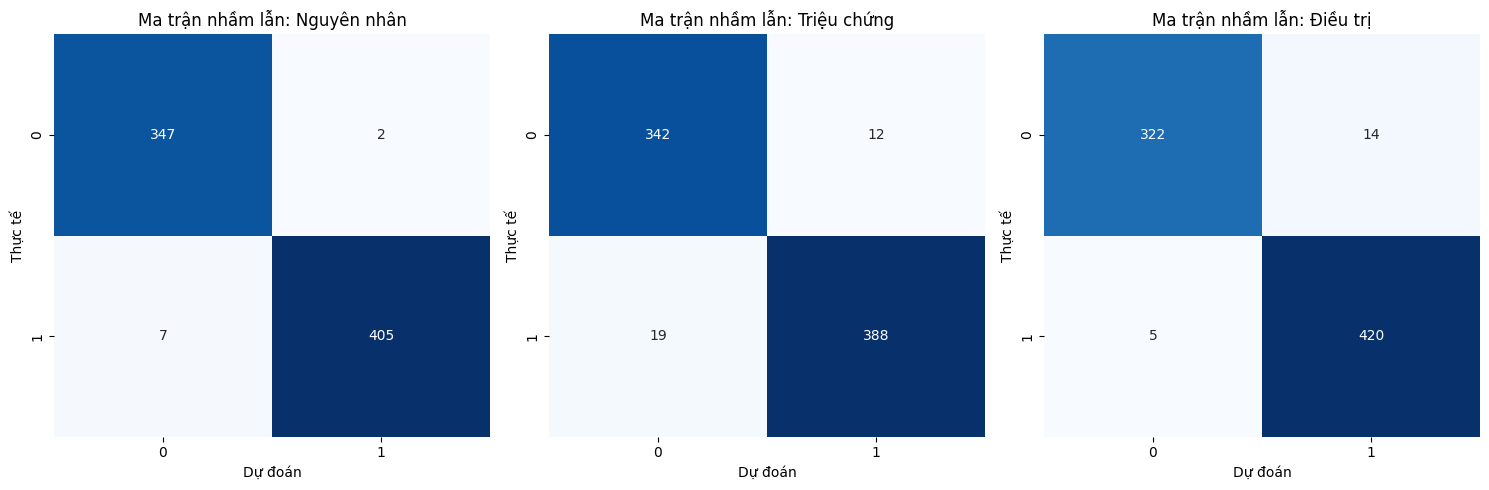

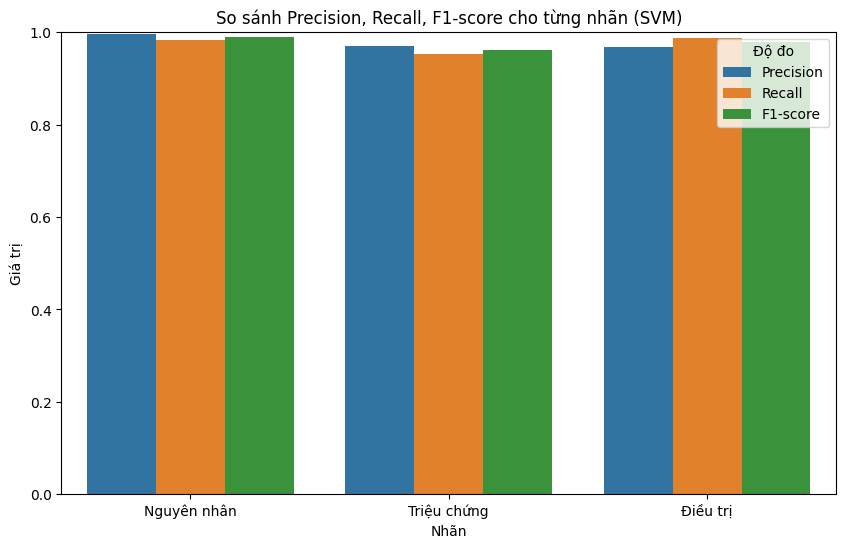

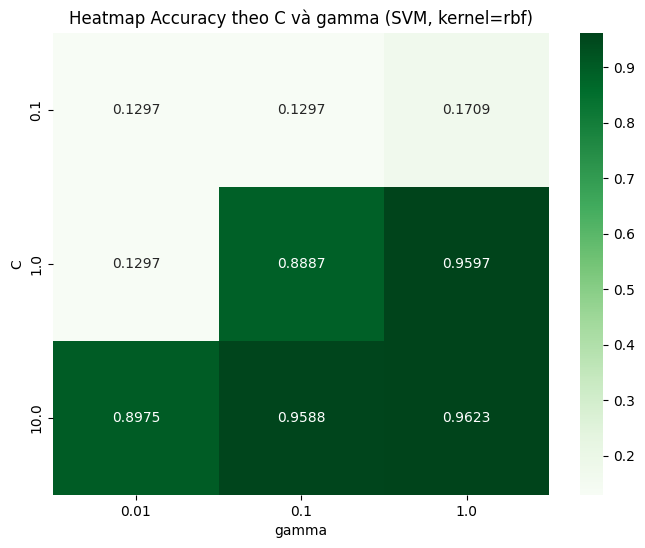

In [24]:
print("\nMa trận nhầm lẫn cho từng nhãn:")
confusion_matrices = []
for i, label in enumerate(mlb.classes_):
    print(f"\nNhãn: {label}")
    cm = confusion_matrix(y_test_svm[:, i], y_pred_svm[:, i])
    confusion_matrices.append(cm)
    print(cm)
    print(f"  True Negative (TN): {cm[0, 0]}")
    print(f"  False Positive (FP): {cm[0, 1]}")
    print(f"  False Negative (FN): {cm[1, 0]}")
    print(f"  True Positive (TP): {cm[1, 1]}")

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(15, 5))
for i, (cm, label) in enumerate(zip(confusion_matrices, mlb.classes_)):
    plt.subplot(1, len(mlb.classes_), i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Ma trận nhầm lẫn: {label}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.xticks([0.5, 1.5], ['0', '1'])
    plt.yticks([0.5, 1.5], ['0', '1'])
plt.tight_layout()
plt.show()

# Trực quan hóa Precision, Recall, F1-score
metrics_df = pd.DataFrame({
    'Nhãn': mlb.classes_,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-score': f1_svm
})
metrics_df = metrics_df.melt(id_vars='Nhãn', var_name='Độ đo', value_name='Giá trị')

plt.figure(figsize=(10, 6))
sns.barplot(x='Nhãn', y='Giá trị', hue='Độ đo', data=metrics_df)
plt.title('So sánh Precision, Recall, F1-score cho từng nhãn (SVM)')
plt.ylim(0, 1)
plt.legend(title='Độ đo')
plt.show()

# Trực quan hóa Accuracy từ Grid Search (biểu đồ đường)
accuracy_results = pd.DataFrame({
    'C': results_svm['param_estimator__C'],
    'gamma': results_svm['param_estimator__gamma'].astype(str),
    'kernel': results_svm['param_estimator__kernel'].astype(str),
    'Accuracy': results_svm['mean_test_score']
})

# Heatmap cho SVM (với kernel=rbf để đơn giản hóa)
svm_pivot = pd.pivot_table(
    pd.DataFrame(results_svm[results_svm['param_estimator__kernel'] == 'rbf']),
    values='mean_test_score',
    index='param_estimator__C',
    columns='param_estimator__gamma'
)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_pivot, annot=True, fmt='.4f', cmap='Greens')
plt.title('Heatmap Accuracy theo C và gamma (SVM, kernel=rbf)')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

## Lưu mô hình

In [25]:
import joblib

joblib.dump(model_RF, "./model/RF.pkl")
joblib.dump(model_svm, "./model/SVM.pkl")
joblib.dump(tfidf, "./model/tfidf_vectorizer.pkl")
joblib.dump(mlb, "./model/mlb.pkl")

print("\nĐã lưu mô hình và các bộ chuyển đổi vào:")
print("- RF.pkl")
print("- SVM.pkl")
print("- tfidf_vectorizer.pkl")
print("- mlb.pkl")


Đã lưu mô hình và các bộ chuyển đổi vào:
- RF.pkl
- SVM.pkl
- tfidf_vectorizer.pkl
- mlb.pkl


# Test mô hình

In [26]:
def extract_disease_name(question, disease_list):
    question_no_accent = unidecode(question.lower())
    best_match = None
    max_length = 0
    
    for disease in disease_list:
        disease_no_accent = unidecode(disease.lower())
        if disease_no_accent in question_no_accent:
            if len(disease_no_accent) > max_length:
                best_match = disease
                max_length = len(disease_no_accent)
    
    return best_match

In [27]:
import joblib
import pandas as pd
from unidecode import unidecode

loaded_model_RF = joblib.load("./model/RF.pkl")
loaded_model_svm = joblib.load("./model/SVM.pkl")
loaded_tfidf = joblib.load("./model/tfidf_vectorizer.pkl")
loaded_mlb = joblib.load("./model/mlb.pkl")
print("\nĐã load mô hình và các bộ chuyển đổi từ file.")

disease_list = sorted(pd.read_csv("data.csv")['Name'].unique().tolist())

question = "Tôi bị bệnh Alzheimer, tôi muốn biết tại sao, cách điều trị và triệu chứng của bệnh."
question_tfidf = loaded_tfidf.transform([question])

y_pred_new_RF = loaded_model_RF.predict(question_tfidf)
detected_intents_RF = loaded_mlb.inverse_transform(y_pred_new_RF)[0]

y_pred_new_svm = loaded_model_svm.predict(question_tfidf)
detected_intents_svm = loaded_mlb.inverse_transform(y_pred_new_svm)[0]

disease_name = extract_disease_name(question, disease_list)

print("\nKiểm tra câu hỏi mới (sử dụng mô hình đã load):")
print(f"Câu hỏi: {question}")
print(f"Các intent phát hiện bởi mô hình Random Forest: {detected_intents_RF}")
print(f"Các intent phát hiện bởi mô hình SVM: {detected_intents_svm}")
print(f"Tên bệnh phát hiện: {disease_name}")


Đã load mô hình và các bộ chuyển đổi từ file.

Kiểm tra câu hỏi mới (sử dụng mô hình đã load):
Câu hỏi: Tôi bị bệnh Alzheimer, tôi muốn biết tại sao, cách điều trị và triệu chứng của bệnh.
Các intent phát hiện bởi mô hình Random Forest: ('Nguyên nhân', 'Triệu chứng', 'Điều trị')
Các intent phát hiện bởi mô hình SVM: ('Nguyên nhân', 'Triệu chứng', 'Điều trị')
Tên bệnh phát hiện: alzheimer


In [28]:
def load_ontology():
    g = Graph()
    g.parse("disease_ontology.owl", format="xml")
    base = "http://example.com/health_qa#"
    n = Namespace(base)
    return g, n

def query_ontology(g, n, disease_name, question_type):
    normalized_name = disease_name.replace(" ", "")
    
    question_type_map = {
        "Triệu chứng": "Symptom",
        "Điều trị": "Treatment",
        "Nguyên nhân": "Cause"
    }
    q_type = question_type_map.get(question_type, "")
    
    if not q_type:
        return ["Không xác định được loại câu hỏi"]
    
    query = f"""
    PREFIX health: <{n}>
    PREFIX rdfs: <{RDFS}>
    
    SELECT ?answer WHERE {{
        ?question a health:Question ;
                  rdfs:label ?question_label ;
                  health:hasAnswer ?answer_obj .
                  
        FILTER(REGEX(STR(?question_label), "{disease_name}", "i") && 
               REGEX(STR(?question_label), "{question_type}", "i"))
               
        ?answer_obj rdfs:label ?answer .
    }}
    """
    
    results = g.query(query)
    answers = [str(row.answer) for row in results]
    
    return answers if answers else ["Không tồn tại"]


In [30]:
g, n = load_ontology()

if disease_name:
    for intent in detected_intents_RF:
        print(f"\nThông tin về {intent.lower()} của bệnh {disease_name}:")
        answers = query_ontology(g, n, disease_name, intent)
        for i, answer in enumerate(answers, 1):
            print(f"- {answer}")
else:
    print("Không thể truy vấn ontology vì không xác định được tên bệnh.")


Thông tin về nguyên nhân của bệnh alzheimer:
- Tích tụ mảng beta-amyloid, Rối loạn protein tau, Yếu tố di truyền, Chế độ ăn uống không lành mạnh, ít vận động, Huyết áp cáo, Tiểu đường, Béo phì

Thông tin về triệu chứng của bệnh alzheimer:
- Giảm trí nhớ, Suy giảm nhận thức, Vong ngôn, Vong tri, Vong hành, Loạn thần,Rối loạn hành vi

Thông tin về điều trị của bệnh alzheimer:
- Chất ức chế cholinesterase, Thuốc đối kháng thụ thể, Thuốc hướng thần, Liệu pháp nhận thức, Chế độ dinh dưỡng hợp lý, Tập thể dục thường xuyên, Duy trì đời sống tinh thần tích cực
